# HMRC Trade, Consumption and Expenditure Exploration

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()
import itertools
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import spearmanr, pearsonr

- Read in processed data files for consumption, expenditure and HMRC imports and exports.
- Create dictionary for mapping the HS4 codes to their descriptions.

In [2]:
consumption_data = pd.read_csv('../data/processed/consumption_final_HS.csv')
expenditure_data = pd.read_csv('../data/processed/expenditure_final_HS.csv')
hmrc_imports = pd.read_csv('../data/processed/hmrc_all_imports.csv')
hmrc_exports = pd.read_csv('../data/processed/hmrc_all_exports.csv')
maffcode_to_HS_mapping = pd.read_csv('../data/processed/maffcode_to_HS_mapping.csv')
consumption_no_deciles  =  pd.read_excel('../data/raw/consumption_no_deciles.xlsx',
                                         sheet_name= ['Household_quantity'], header= None)
expenditure_no_deciles  =  pd.read_excel('../data/raw/expenditure_no_deciles.xlsx',
                                         sheet_name= ['expenditure'], header= None)
price_quotes_HS4 = pd.read_csv('../data/processed/final_price_quotes_HS4_clustering.csv')

dict_hs4_codes = {201:'fresh_beef', 202:'frozen_beef', 203:'pork', 204:'sheep_goat_meat',
                  206:'edible_offal_not_poultry', 207:'poultry_incl_edible_offal',
                  210:'salted_dried_smoked_meat_and_offal', 305:'salted_dried_smoked_fish',
                  401:'unsweetened_milk_cream', 405:'dairy_butter_fats_oils_spreads', 406:'cheese_and_curd',
                  409:'natural_honey', 701:'fresh_potatoes', 901:'coffee', 902:'tea', 1004:'oats', 1006:'rice',
                  1107:'malt', 1501:'pig_poultry_fat', 1515:'vegetable_fats_oils', 1601:'sausages_processed_meats',
                  1602:'prep_pres_meat_meatoffal', 1604:'prep_pres_fish_fisheggs', 1703:'molasses',
                  1704:'sugar_confec_no_cocoa', 1806:'chocolate_prep_cocoa', 1902:'pasta_noodles',
                  1905:'bread_biscuits_cakes_pastry', 2001:'prep_pres_veg_fruit_nuts',
                  2007:'jam_jelly_fruit-nut_paste', 2008:'prep_pres_fruit_nuts_notinvinegar',2103:'sauces_condiments',
                  2104:'soup_broth', 2105:'ice-cream', 2106:'prep_foods_misc', 2201:'unsweetened_water',
                  2202:'soft_drinks_not_fruitjuice', 2203:'beer', 2204:'wine', 2206:'fermented_drinks',
                  2208:'spirits_liqueurs'}

## Format consumption, expenditure, imports and exports data
- Unpivot the consumption and expenditure data frames: convert the dataframe from a wide format to a long format for easier manipulation.

In [3]:
consumption_long_fmt = pd.melt(consumption_data, value_vars= ['2008','2009','2010','2011','2012','2013','2014','2015',
                                                              '2016','2017'],
                               var_name = 'year', value_name = 'consumption_amount_grams',
                               id_vars = ['Description', 'HS2', 'HS4', 'RSE_percent', 'decile'])
# Filter out the rows with HS2 = 25 (salt)
consumption_long_fmt = consumption_long_fmt.loc[~(consumption_long_fmt['HS2'] == 25), :]
# Make the year values integer
consumption_long_fmt.loc[:, 'year'] = consumption_long_fmt.loc[:, 'year'].astype(int)
# Convert maffcodes to HS convention
maffcode_to_HS_mapping.columns = ['MAFFCODE', 'HS2_code', 'HS4_code', 'Description']

## HS4 variance analysis
- This section looks at the standard deviation of the fractional year-on-year (yoy) change in the consumption, expenditure and import trade data for each HS4 code.
- The fractional year-on-year change is the difference in values between two consecutives years divided by the original year.
- For example one data point could be the difference in total consumption between 2016 and 2015 divided by the total consumption in 2015.

In [4]:
years = list(np.arange(1974,2018))

def clean_consumption_expenditure_data(df, sheet_name, data_content = 'consumption'):
    '''
    Extract data from 1974 - 2018, keep only those rows with 2nd level of refinement and remove NA values.
    Parameters:
    ----------------
    df: raw dataframe of consumption or expenditure data (without decile segregation)
    sheet_name: sheet name of the excel file that contains relevant data.
    data_content: either 'expenditure' or 'consumption' data.
    Returns:
    ----------------
    df: cleaned dataframe of either consumption or expenditure data, no NANs and up to HS2 level.
    '''
    if data_content == 'consumption':
        df = df[sheet_name].iloc[8:345,:51]
    elif data_content == 'expenditure':
        df = df[sheet_name].iloc[24:369,:51]
    else:
        print("Enter either expenditure or consumption for data content!")
        return None
    # Drop column 48 which is 201516 in the excel file 
    df = df.drop([1,3,4,5,48], axis=1)
    df = df.dropna(subset = [2])
    # Name the columns     
    maff_descr = [["MAFF_code"],["Description"]]
    maff_descr.append(years)
    df.columns = [val for sublist in maff_descr for val in sublist]
    return df

def merge_maffcode_HS2_mapping(df):
    '''
    Merge the expenditure or consumption dataframe containing MAFFCODEs with their corresponding HS2/HS4 codes.
    Parameters:
    ----------------
    df: dataframe of consumption or expenditure data containing MAFFCODEs.
    Returns:
    ----------------
    merged_df: merged dataframe of either consumption or expenditure data with their HS2 and HS4 codes.
    '''
    merged_df = pd.merge(df, maffcode_to_HS_mapping, on = 'Description')
    merged_df.drop(['MAFF_code', 'MAFFCODE'], axis = 1, inplace = True)
    return merged_df

def unpivot_dataframe_and_remove_HS2_25(df, value_name = 'consumption_amount_grams'):
    '''
    Unpivot dataframes: convert the dataframe from a wide format to a long format for easier manipulation.
    Remove HS2 code of 25 (salt).
    Parameters:
    ----------------
    df: consumption and expenditure dataframes.
    value_name: column name for variable in the pandas melt function.
    Returns:
    ----------------
    long_fmt_df: long format dataframe
    '''
    non_numeric_year_cols = df.select_dtypes(exclude=np.number).columns.drop('Description')
    df.loc[:,non_numeric_year_cols] = df[non_numeric_year_cols].apply(pd.to_numeric).copy()
    long_fmt_df = pd.melt(df, value_vars = years, var_name = 'year', 
                          value_name = value_name, id_vars = ['Description', 'HS2_code', 'HS4_code'])
    # To remove HS2 of 25 (salt)
    long_fmt_df = long_fmt_df.loc[~(long_fmt_df.HS2_code == 25),:].copy()
    return long_fmt_df

def groupby_HS4(df, colname = 'consumption_amount_grams'):
    '''
    Find the sum and mean for each HS4 code and for each year of the data.
    Drop NANs.
    Parameters:
    ----------------
    df: consumption, expenditure, imports or exports dataframes.
    colname: the column name for the chosen variable to find the sum and mean of.
    Returns:
    ----------------
    groupby_HS4_year_df: dataframe containing columns for the sum and mean of each HS4 code for each year.
    '''   
    df = df.dropna(subset = ['HS4_code'])
    df.loc[:, 'HS4_code'] = df.loc[:,'HS4_code'].astype(int).copy()
    groupby_HS4_year_df = df.groupby(['HS4_code', 'year'])[colname].agg(['sum','mean'])
    return groupby_HS4_year_df

def compute_yoy_std(groupby_hs4_year_df, data_content = 'consumption'):
    '''
    This calculates the standard deviation of the fractional year-on-year change of a variable.
    The values are sorted in order of size.
    Parameters:
    ----------------
    groupby_hs4_year_df: dataframe previously grouped by HS4 code and year.
    data_content: the type of data to look at; consumption or expenditure.
    Returns:
    ----------------
    hs4_std_values_df_sort: dataframe containing sorted values of the standard deviation of the fractional
    year-on-year change for each HS4 code.
    '''     
    hs4_std_values = {}
    for hs4_code in hs4_codes:
        hs4_df = groupby_hs4_year_df.loc[(hs4_code,),'sum']
        if 0. in hs4_df.values:
            arr = hs4_df.loc[~(hs4_df == 0.)][:-1]
            hs4_df_diff = hs4_df.diff().dropna()
            diff = hs4_df_diff.loc[~(hs4_df_diff == 0.)][1:]
            yoy_change_HS4 = diff.values/arr.values
            hs4_std_values[hs4_code] = yoy_change_HS4.std()
        else:
            delta_y = groupby_hs4_year_df.loc[(hs4_code,),'sum'].diff().dropna()
            yoy_change_HS4 = delta_y.values / groupby_hs4_year_df.loc[(hs4_code,),'sum'][:-1].values
            hs4_std_values[hs4_code] = yoy_change_HS4.std()
    hs4_std_values_df = pd.DataFrame.from_dict(hs4_std_values, orient='index').reset_index()
    hs4_std_values_df.columns = ['HS4_code', '{}_yoy_st_dev'.format(data_content)]
    hs4_std_values_df.loc[:, 'description'] = hs4_std_values_df.HS4_code.apply(lambda code : dict_hs4_codes[code])
    hs4_std_values_df_sort = hs4_std_values_df.sort_values("{}_yoy_st_dev".format(data_content)).reset_index(drop=True)
    return hs4_std_values_df_sort

def compute_yoy_std_hmrc(groupby_df, hs4_codes, trade = 'import'):
    '''
    This calculates the standard deviation of the fractional year-on-year change of a particular trade.
    The values are sorted in order of size.
    Parameters:
    ----------------
    groupby_df: dataframe previously grouped by HS4 code and year.
    hs4_codes: list of HS4 codes.
    trade: type of trade either import or export.
    Returns:
    ----------------
    hs4_std_values_df: dataframe containing values of the the standard deviation of the fractional year-on-year change
    of a particular trade for each HS4 code.
    '''  
    hs4_std_values = {}
    for hs4_code in hs4_codes:
        arr = groupby_df.loc[(hs4_code,),'sum']
        arr_diff = arr.diff()
        yoy_change = arr_diff[1:].values/arr[:-1].values
        hs4_std_values[hs4_code] = yoy_change.std()
    hs4_std_values_df = pd.DataFrame.from_dict(hs4_std_values, orient='index').reset_index()
    hs4_std_values_df.columns = ['HS4_code', '{}_yoy_st_dev'.format(trade)]
    hs4_std_values_df = hs4_std_values_df.sort_values("{}_yoy_st_dev".format(trade)).reset_index(drop=True)
    return hs4_std_values_df

### Format consumption and expenditure data

In [5]:
consumption_no_deciles = clean_consumption_expenditure_data(df=consumption_no_deciles,
                                                            sheet_name = 'Household_quantity', 
                                                            data_content = 'consumption')
consumption_no_deciles_HS4 = merge_maffcode_HS2_mapping(consumption_no_deciles)
consumption_long_fmt_HS4 = unpivot_dataframe_and_remove_HS2_25(consumption_no_deciles_HS4,
                                                               value_name = 'consumption_amount_grams')
consumption_HS4_year = groupby_HS4(consumption_long_fmt_HS4, colname = 'consumption_amount_grams')
hs4_codes = list(consumption_HS4_year.index.get_level_values(level = 0).unique())
expenditure_no_deciles = clean_consumption_expenditure_data(expenditure_no_deciles,
                                                            sheet_name = 'expenditure',
                                                            data_content = 'expenditure')
# merge maffcode mappings to HS2 and HS4
expenditure_no_deciles_HS4 = merge_maffcode_HS2_mapping(expenditure_no_deciles)
# further cleaning and convert to a long format dataframe
expenditure_long_fmt_HS4 = unpivot_dataframe_and_remove_HS2_25(expenditure_no_deciles_HS4,
                                                               value_name = 'expenditure_pp_pw_pence')
# Group by HS4 and year and aggregate (sum,mean,median) the values
expenditure_HS4_year = groupby_HS4(expenditure_long_fmt_HS4, colname = 'expenditure_pp_pw_pence')

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Standard deviation of fractional year-on-year (yoy) change
### Consumption

In [6]:
consumption_hs4_std = compute_yoy_std(consumption_HS4_year, data_content = 'consumption')

In [7]:
#for i in range(len(consumption_hs4_std['HS4_code'])):
#    consumption_hs4_std['HS4_code'][i] = 'HS%04d' % consumption_hs4_std['HS4_code'][i]

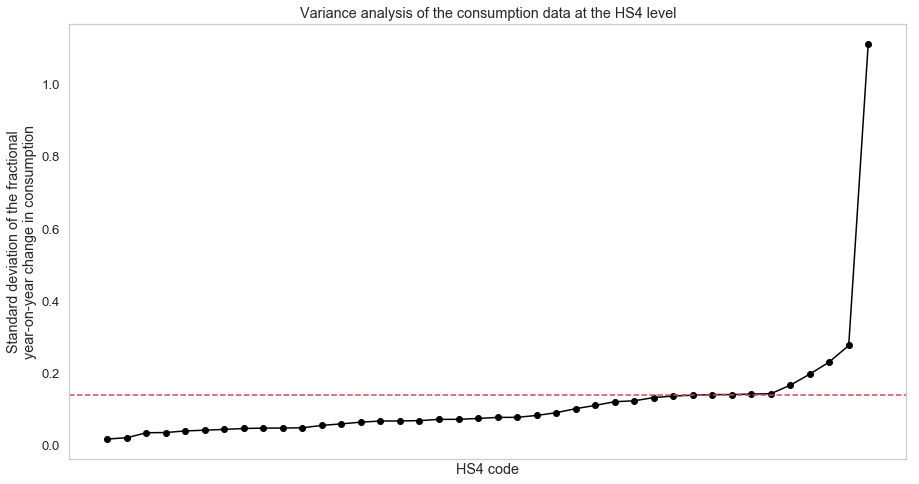

In [8]:
plt.figure(figsize=(15,8))
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'axes.grid' : False})
_ = plt.plot(consumption_hs4_std.index, consumption_hs4_std.consumption_yoy_st_dev, "-o", lw=1.5, color='black')
#_ = plt.xticks(ticks=consumption_hs4_std.index, labels = consumption_hs4_std.HS4_code, rotation=90)
_ = plt.xticks([],[])
_ = plt.axhline(y=0.138559, xmin=0.0, xmax=1.0, color='r', linestyle='dashed')
_ = plt.xlabel("HS4 code")
_ = plt.ylabel("Standard deviation of the fractional\nyear-on-year change in consumption")
_ = plt.title("Variance analysis of the consumption data at the HS4 level")

### Expenditure

In [9]:
expenditure_hs4_std = compute_yoy_std(expenditure_HS4_year, data_content = 'expenditure')

In [10]:
#for i in range(len(expenditure_hs4_std['HS4_code'])):
#    expenditure_hs4_std['HS4_code'][i] = 'HS%04d' % expenditure_hs4_std['HS4_code'][i]

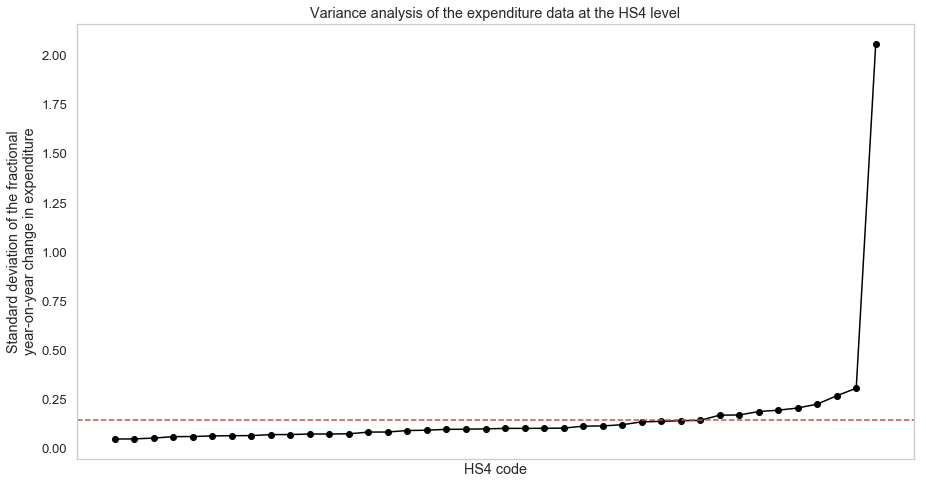

In [11]:
plt.figure(figsize=(15,8))
_ = plt.plot(expenditure_hs4_std.index, expenditure_hs4_std.expenditure_yoy_st_dev, "-o", lw=1.5, color='black')
#_ = plt.xticks(ticks=expenditure_hs4_std.index, labels = expenditure_hs4_std.HS4_code, rotation=90)
_ = plt.xticks([],[])
_ = plt.axhline(y=0.142842, xmin=0.0, xmax=1.0, color='r', linestyle='dashed')
_ = plt.xlabel("HS4 code")
_ = plt.ylabel("Standard deviation of the fractional\nyear-on-year change in expenditure")
_ = plt.title("Variance analysis of the expenditure data at the HS4 level")

In [12]:
cons_exp_std_merged = pd.merge(consumption_hs4_std,expenditure_hs4_std, on = 'description', how = 'outer')
cons_exp_std_merged.drop('HS4_code_y', axis=1, inplace = True)
cons_exp_std_merged.rename(columns = {'HS4_code_x': 'HS4_code'}, inplace = True)

### HMRC imports

In [13]:
hmrc_imports_by_HS4_year = hmrc_imports.groupby(['HS4_code', 'year'])['values_pounds'].agg(['sum', 'mean'])
hmrc_imports_hs4_codes = list(hmrc_imports.HS4_code.unique())
imports_hs4_std_values_df = compute_yoy_std_hmrc(hmrc_imports_by_HS4_year, hmrc_imports_hs4_codes, 'import')

In [14]:
#for i in range(len(imports_hs4_std_values_df['HS4_code'])):
#    imports_hs4_std_values_df['HS4_code'][i] = 'HS%04d' % imports_hs4_std_values_df['HS4_code'][i]

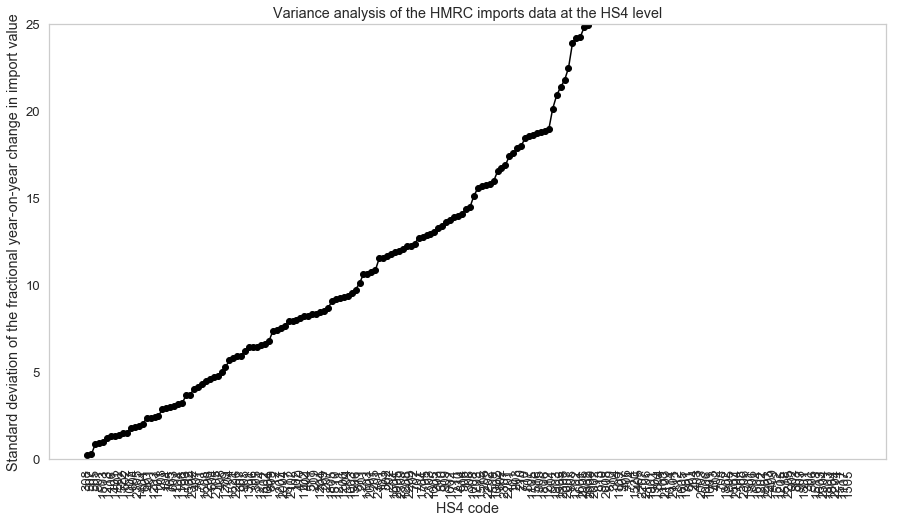

In [15]:
plt.figure(figsize=(15,8))
_ = plt.plot(imports_hs4_std_values_df.index, imports_hs4_std_values_df.import_yoy_st_dev, "-o", lw=1.5, color='black')
_ = plt.xticks(ticks=imports_hs4_std_values_df.index, labels = imports_hs4_std_values_df.HS4_code, rotation=90)
_ = plt.xlabel("HS4 code")
_ = plt.ylabel("Standard deviation of the fractional year-on-year change in import value")
_ = plt.ylim(0,25)
_ = plt.title("Variance analysis of the HMRC imports data at the HS4 level")

### HMRC exports

In [16]:
hmrc_exports_by_HS4_year = hmrc_exports.groupby(['HS4_code', 'year'])['values_pounds'].agg(['sum', 'mean'])
hmrc_exports_hs4_codes = list(hmrc_exports.HS4_code.unique())
imports_hs4_std_values_df = compute_yoy_std_hmrc(hmrc_exports_by_HS4_year, hmrc_exports_hs4_codes, trade = 'export')

In [17]:
#for i in range(len(imports_hs4_std_values_df['HS4_code'])):
#    imports_hs4_std_values_df['HS4_code'][i] = 'HS%04d' % imports_hs4_std_values_df['HS4_code'][i]

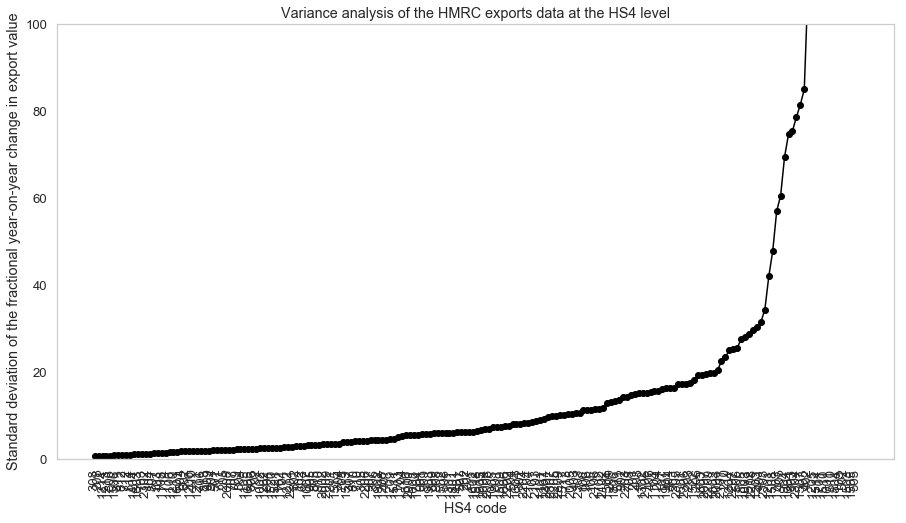

In [18]:
plt.figure(figsize=(15,8))
_ = plt.plot(imports_hs4_std_values_df.index, imports_hs4_std_values_df.export_yoy_st_dev, "-o", lw=1.5, color='black')
_ = plt.xticks(ticks=imports_hs4_std_values_df.index, labels = imports_hs4_std_values_df.HS4_code, rotation=90)
_ = plt.xlabel("HS4 code")
_ = plt.ylabel("Standard deviation of the fractional year-on-year change in export value")
_ = plt.ylim(0,100)
_ = plt.title("Variance analysis of the HMRC exports data at the HS4 level")

## Correlations between consumption, expenditure and imports

- This section looks at the correlation coefficient between consumption and expenditure, consumptiona and imports and expenditure and imports at HS4 level.

In [19]:
def get_corr_coeff(ser1, ser2, corr_type = 'pearson'):
    '''
    Returns the correlation coefficient and p-value between two data sets.
    Parameters:
    ----------------
    ser1: 1st dataset.
    ser2: 2nd datset.
    corr_type: correlation type, either 'pearson' or 'spearman'.
    Returns:
    ----------------
    coeff_and_pval_tuple: tuple of the correlation coefficient and corresponding p-value.
    '''
    if corr_type == 'pearson':
        coeff_and_pval_tuple = pearsonr(ser1, ser2)
    elif corr_type == 'spearman':
        coeff_and_pval_tuple = spearmanr(ser1, ser2)  
    else:
        print('Wrong corr_type or unequal lengths of the datasets')
        return None
    return coeff_and_pval_tuple

def get_correlation_table(df, qty1, qty2, codes_list, code_res = 'HS2', corr_type = 'pearson'):
    '''
    Generates a dataframe containing the correlation coefficient and corresponding p-value between two datasets.
    Parameters:
    ----------------
    df: dataframe with relevant data to find correlation between.
    qty1: 1st quantity to find the correlation between.
    qty2: 2nd quantity.
    codes_list: list of either HS2 or HS4 codes.
    code_res: 'HS2' or 'HS4'.
    corr_type: correlation type, either 'pearson' or 'spearman'.
    Returns:
    ----------------
    corr_df: dataframe containing the correlation coefficient and corresponding p-value.
    '''
    corr_dict = {}
    for code in codes_list:
        coef,p = get_corr_coeff(df.loc[code,qty1], df.loc[code, qty2],corr_type = corr_type)
        if  code_res == 'HS2':
            corr_dict[code] = [round(coef,2),p, dict_hs2_codes[code]]
        elif code_res == 'HS4':
            corr_dict[code] = [round(coef,2),p, dict_hs4_codes[code]]
    corr_df = pd.DataFrame.from_dict(corr_dict, orient='index').reset_index()
    corr_df.columns = ['code', '{}_corrcoef'.format(corr_type),'p-value', 'description']
    corr_df = corr_df.sort_values(by = '{}_corrcoef'.format(corr_type))
    return corr_df

### Format consumption, expenditure and imports data

In [20]:
imports_exports_joined_by_HS4 = pd.merge(hmrc_imports_by_HS4_year, hmrc_exports_by_HS4_year, how = 'inner',
                                         on = ['HS4_code', 'year'])
imports_exports_joined_by_HS4.columns = ['total_import_value_gbp','mean_import_value_gbp',
                                         'total_export_value_gbp', 'mean_export_value_gbp']
imp_exp_consumption_joined_by_HS4 = pd.merge(imports_exports_joined_by_HS4, consumption_HS4_year,
                                             how = 'inner', on = ['HS4_code', 'year'])
imp_exp_consumption_joined_by_HS4.columns = ['total_import_value_gbp','mean_import_value_gbp',
                                             'total_export_value_gbp', 'mean_export_value_gbp',
                                             'total_consumption_pp_pw_g', 'mean_consumption_pp_pw_g']
trade_cons_expenditure_data_joined_by_HS4 = pd.merge(imp_exp_consumption_joined_by_HS4, expenditure_HS4_year,
                                                     how = 'inner', on = ['HS4_code', 'year'])
trade_cons_expenditure_data_joined_by_HS4.columns = ['total_import_value_gbp','mean_import_value_gbp',
                                                     'total_export_value_gbp', 'mean_export_value_gbp',
                                                     'total_consumption_pp_pw_g', 'mean_consumption_pp_pw_g',
                                                     'total_exp_pp_pw_pence', 'mean_exp_pp_pw_pence']
pearson_corr_HS4_imp_expend = get_correlation_table(df=trade_cons_expenditure_data_joined_by_HS4,
                                                    qty1 = 'total_import_value_gbp', qty2 = 'total_exp_pp_pw_pence',
                                                    codes_list = hs4_codes, code_res = 'HS4', corr_type = 'pearson')
pearson_corr_HS4_imp_expend = pearson_corr_HS4_imp_expend.rename(columns = {'pearson_corrcoef':
                                                                            'ps_corrcoef_imp_expend'})
pearson_corr_HS4_cons_expend = get_correlation_table(df=trade_cons_expenditure_data_joined_by_HS4,
                                                     qty1 = 'total_consumption_pp_pw_g',
                                                     qty2 = 'total_exp_pp_pw_pence', codes_list = hs4_codes,
                                                     code_res = 'HS4', corr_type = 'pearson')
pearson_corr_HS4_cons_expend = pearson_corr_HS4_cons_expend.rename(columns = {'pearson_corrcoef':
                                                                              'ps_corrcoef_cons_expend'})
pearson_corr_HS4_imp_cons = get_correlation_table(df=trade_cons_expenditure_data_joined_by_HS4,
                                                  qty1 = 'total_consumption_pp_pw_g',qty2 = 'total_import_value_gbp',
                                                  codes_list = hs4_codes, code_res = 'HS4', corr_type = 'pearson')
pearson_corr_HS4_imp_cons = pearson_corr_HS4_imp_cons.rename(columns = {'pearson_corrcoef': 'ps_corrcoef_cons_imp'})
pearson_corr_HS4_merge1 = pd.merge(pearson_corr_HS4_imp_expend, pearson_corr_HS4_cons_expend, how = 'inner',
                                   on = 'description')
pearson_corr_HS4_merge1 = pearson_corr_HS4_merge1.drop('code_y', axis =1)
pearson_corr_HS4_merge1 = pearson_corr_HS4_merge1.rename(columns = {'code_x': 'HS4_code', 'p-value_x':
                                                                    'p-value_imp_expend', 'p-value_y':
                                                                    'p-value_cons_expend'})
pearson_merge = pd.merge(pearson_corr_HS4_merge1, pearson_corr_HS4_imp_cons, how = 'inner', on = 'description')
pearson_merge = pearson_merge.drop('code', axis = 1)
pearson_merge = pearson_merge.rename(columns = {'p-value': 'p-value_imp_cons'})
pearson_std_merge = pd.merge(pearson_merge, cons_exp_std_merged, on = ['HS4_code','description'])
pearson_std_merge[sorted(pearson_std_merge.columns)]

,HS4_code,consumption_yoy_st_dev,description,expenditure_yoy_st_dev,p-value_cons_expend,p-value_imp_cons,p-value_imp_expend,ps_corrcoef_cons_expend,ps_corrcoef_cons_imp,ps_corrcoef_imp_expend
0,1107,0.196793,malt,0.205692,3.811674e-06,0.005179,0.007705,0.97,-0.80,-0.78
1,1501,0.142459,pig_poultry_fat,0.187578,6.726569e-04,0.431512,0.186026,0.88,-0.28,-0.46
2,401,0.020575,unsweetened_milk_cream,0.073487,5.025594e-03,0.019054,0.358180,0.80,-0.72,-0.33
3,203,0.073877,pork,0.092762,4.330602e-04,0.187187,0.574186,0.90,-0.45,-0.20
4,2007,0.047391,jam_jelly_fruit-nut_paste,0.091239,1.201394e-01,0.000764,0.598810,0.52,-0.88,-0.19
5,204,0.122941,sheep_goat_meat,0.102483,1.288063e-02,0.380596,0.833056,0.75,-0.31,0.08
6,902,0.046153,tea,0.141071,4.476982e-02,0.064052,0.730476,0.64,-0.60,0.13
7,210,0.034959,salted_dried_smoked_meat_and_offal,0.052849,2.639112e-02,0.847654,0.303011,0.69,0.07,0.36
8,1515,0.136011,vegetable_fats_oils,0.137898,3.724912e-01,0.258581,0.297464,0.32,-0.40,0.37
9,206,0.140253,edible_offal_not_poultry,0.142842,3.760897e-02,0.496679,0.284705,0.66,0.24,0.38


### Scale
- We define the scale of a food industry as the sum of the total UK population expenditure and the total imports and exports value.

In [21]:
population_UK = 64900000. #Check - this is all of the UK
scale_HS4 = {}
for hs4_code in hs4_codes:
    df = trade_cons_expenditure_data_joined_by_HS4.loc[hs4_code,:]
    total_expen_yearly_gbp =  df['total_exp_pp_pw_pence'].sum()*52*population_UK/100
    # Find the average scale of the industry per year (in units of GBP)
    scale = (df['total_import_value_gbp'].sum() + df['total_export_value_gbp'].sum() + total_expen_yearly_gbp)/10
    scale_HS4[hs4_code] = scale
scale_HS4_df = pd.DataFrame.from_dict(scale_HS4,orient = 'index').reset_index()
scale_HS4_df.columns = ['HS4_code', 'scale_gbp']

### Correlation and scale results
- Plots of the correlation coefficient and scale for each HS4 code.

In [22]:
# Merge scale with dataframe containing the y-o-y change data and the correlation data.
pearson_std_scale_merge = pd.merge(pearson_std_merge, scale_HS4_df, on = 'HS4_code')
pearson_std_scale_merge = pearson_std_scale_merge.sort_values('ps_corrcoef_cons_imp').reset_index(drop = True)

In [23]:
#for i in range(len(pearson_std_scale_merge['HS4_code'])):
#    pearson_std_scale_merge['HS4_code'][i] = 'HS%04d' % pearson_std_scale_merge['HS4_code'][i]

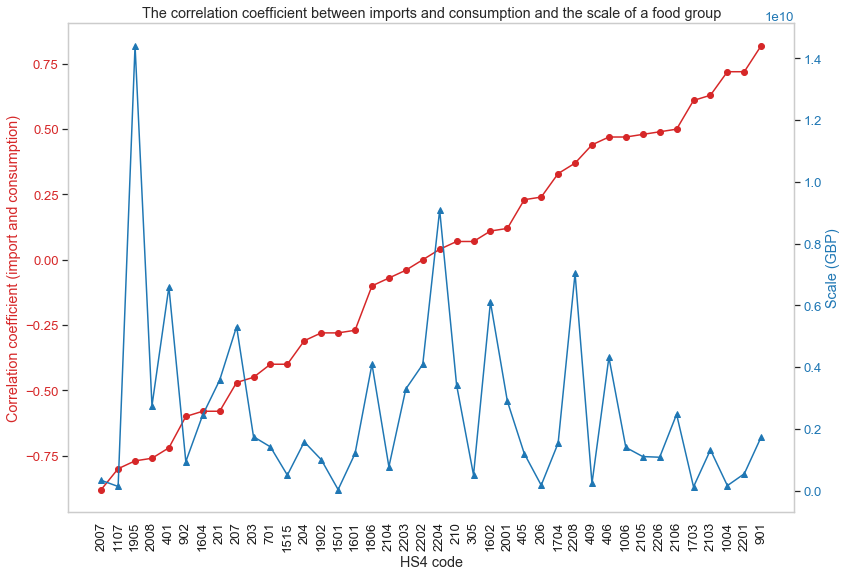

In [24]:
fig, ax1 = plt.subplots(figsize = (12,8))
plt.title("The correlation coefficient between imports and consumption and the scale of a food group")

color = 'tab:red'
ax1.set_xlabel('HS4 code')
ax1.set_ylabel('Correlation coefficient (import and consumption)', color=color)
ax1.plot(pearson_std_scale_merge.index, pearson_std_scale_merge.ps_corrcoef_cons_imp, color = color, marker = 'o', ls = None)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Scale (GBP)', color=color)
ax2.plot(pearson_std_scale_merge.index, pearson_std_scale_merge.scale_gbp, color=color, marker = '^', ls = None)
ax2.tick_params(axis='y', labelcolor=color)
plt.xticks(ticks = pearson_std_scale_merge.index, labels = pearson_std_scale_merge.HS4_code, rotation=90)
fig.tight_layout()
ax1.tick_params(axis='x', which='major', labelcolor='k', rotation=90)

In [25]:
max_scale_gbp = pearson_std_scale_merge.scale_gbp.max()

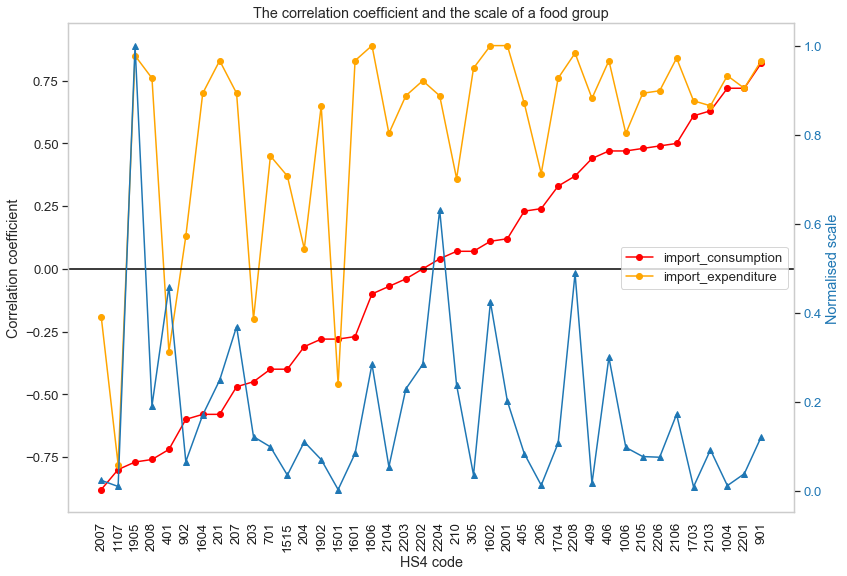

In [26]:
fig, ax1 = plt.subplots(figsize = (12,8))
plt.title("The correlation coefficient and the scale of a food group")

ax1.set_xlabel('HS4 code')
ax1.set_ylabel('Correlation coefficient')
ax1.plot(pearson_std_scale_merge.index, pearson_std_scale_merge.ps_corrcoef_cons_imp, color = "red", marker = 'o',
         label = "import_consumption", ls = None)
ax1.plot(pearson_std_scale_merge.index, pearson_std_scale_merge.ps_corrcoef_imp_expend, color = 'orange',
         marker = 'o', label = "import_expenditure", ls = None)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax1.axhline(color="black")

color = 'tab:blue'
ax2.set_ylabel('Normalised scale', color=color) 
ax2.plot(pearson_std_scale_merge.index, pearson_std_scale_merge.scale_gbp / max_scale_gbp, color=color, marker = '^', ls = None)
ax2.tick_params(axis='y', labelcolor=color)
plt.xticks(ticks = pearson_std_scale_merge.index, labels = pearson_std_scale_merge.HS4_code, rotation=90)
fig.tight_layout()
ax1.tick_params(axis='x', which='major', labelcolor='k', rotation=90)

ax1.legend(loc='center right')

## Price quote data
- Include the mean and median prices of each HS4 code averaged over all the regions in the UK.

### Format price quotes data

In [27]:
hs4_codes_pq = price_quotes_HS4.HS4.unique()
price_quotes_HS4 = price_quotes_HS4.set_index(['HS4','year'])

In [28]:
def compute_yoy_std_price_quotes(groupby_df, hs4_codes):
    '''
    This computes the standard deviation of the year-on-year change of the price quotes data for each HS4 code.
    It sorts the values in order of size.
    Parameters:
    ----------------
    groupby_df: dataframe previously grouped by HS4 code and year.
    hs4_codes: list of HS4 codes.
    Returns:
    ----------------
    hs4_std_values_df: dataframe containing the sorted standard deviation values of the year-on-year change of the
    price quotes data for each HS4 code.
    '''
    hs4_std_values = {}
    for hs4_code in hs4_codes:
        arr = groupby_df.loc[(hs4_code,),'mean_price_gbp']
        arr_diff = arr.diff()
        yoy_change = arr_diff[1:].values/arr[:-1].values
        hs4_std_values[hs4_code] = yoy_change.std()
    hs4_std_values_df = pd.DataFrame.from_dict(hs4_std_values, orient='index').reset_index()
    hs4_std_values_df.columns = ['HS4_code', 'price_quotes_yoy_st_dev']
    hs4_std_values_df = hs4_std_values_df.sort_values("price_quotes_yoy_st_dev").reset_index(drop=True)
    return hs4_std_values_df

In [29]:
price_quotes_HS4_yoy_st_dev = compute_yoy_std_price_quotes(price_quotes_HS4, hs4_codes_pq)
price_quotes_HS4_yoy_st_dev.rename(columns = {'HS4':'HS4_code'}, inplace=True)
pearson_std_scale_pq_merge = pd.merge(pearson_std_scale_merge, price_quotes_HS4_yoy_st_dev, on = 'HS4_code')

### Combined standard deviation of the fractional year-on-year change in consumption and price quotes results

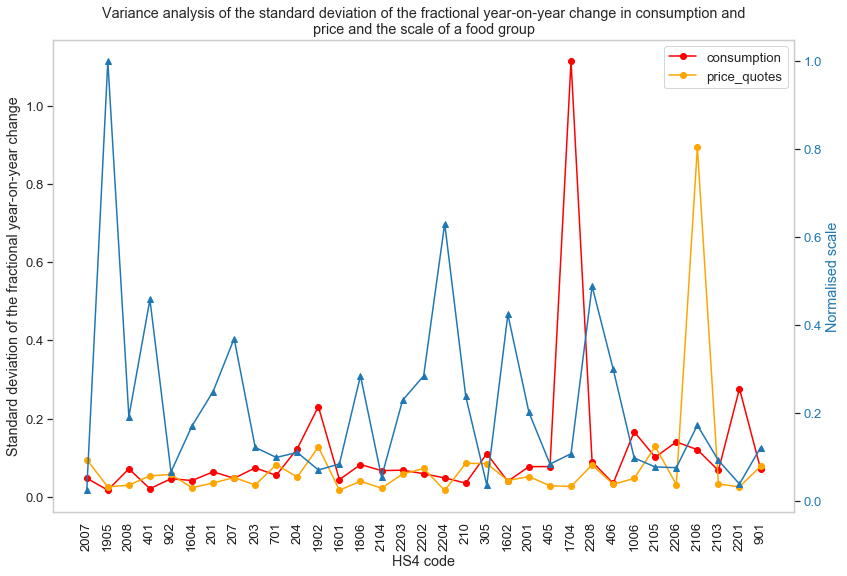

In [30]:
fig, ax1 = plt.subplots(figsize = (12,8))
plt.title('''Variance analysis of the standard deviation of the fractional year-on-year change in consumption and
price and the scale of a food group''')

ax1.set_xlabel('HS4 code')
ax1.set_ylabel('Standard deviation of the fractional year-on-year change')
ax1.plot(pearson_std_scale_pq_merge.index, pearson_std_scale_pq_merge.consumption_yoy_st_dev,
         color = "red", marker = 'o', label = "consumption", ls = None)
ax1.plot(pearson_std_scale_pq_merge.index, pearson_std_scale_pq_merge.price_quotes_yoy_st_dev,
         color = 'orange', marker = 'o', label = "price_quotes", ls = None)
ax1.tick_params(axis='y')

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('Normalised scale', color=color)
ax2.plot(pearson_std_scale_pq_merge.index, pearson_std_scale_pq_merge.scale_gbp / max_scale_gbp, color=color,
         marker = '^', ls = None)
ax2.tick_params(axis='y', labelcolor=color)
plt.xticks(ticks = pearson_std_scale_pq_merge.index, labels = pearson_std_scale_pq_merge.HS4_code, rotation=90)
fig.tight_layout()
ax1.tick_params(axis='x', which='major', labelcolor='k', rotation=90)

ax1.legend()

## Scoring
- In order to quantify a vulnerable food industry we have defined a score.
- score = the arithmetic mean of the magnitude of the correlation coefficient between consumption and imports and the magnitude of the correlation coefficient between expenditure and imports
- score > 0.7 => vulnerable food industry

### Format score data

In [31]:
pearson_std_scale_merge['score'] = 0.5*(abs(pearson_std_scale_merge.ps_corrcoef_cons_imp) +
                                        abs(pearson_std_scale_merge.ps_corrcoef_imp_expend))
scale_norm_max = (pearson_std_scale_merge.scale_gbp / max_scale_gbp)
scale_norm_sum = pearson_std_scale_merge.scale_gbp / pearson_std_scale_merge.scale_gbp.sum()
pearson_std_scale_merge = pearson_std_scale_merge.sort_values('score').reset_index(drop=True)

### Score and scale results

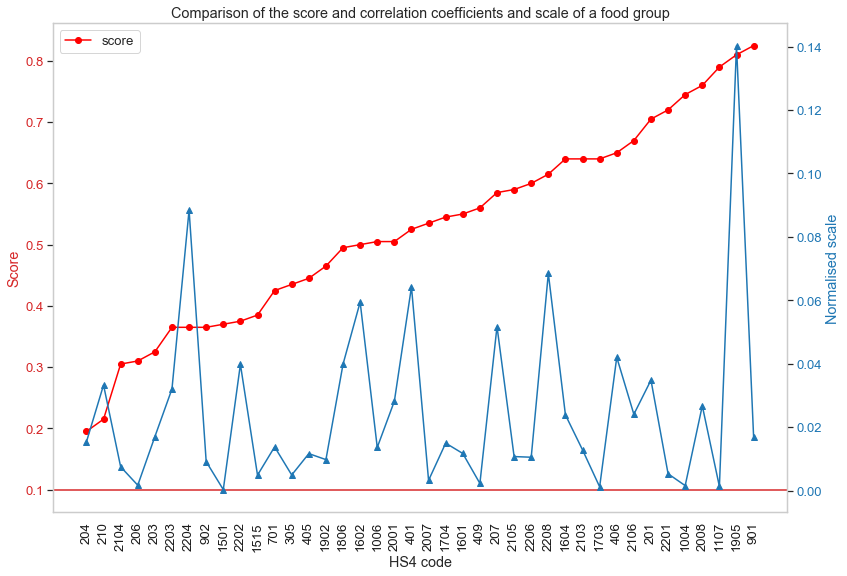

In [32]:
fig, ax1 = plt.subplots(figsize = (12,8))
plt.title("Comparison of the score and correlation coefficients and scale of a food group")

color = 'tab:red'
ax1.set_xlabel('HS4 code')
ax1.set_ylabel('Score', color=color)
ax1.plot(pearson_std_scale_merge.index, pearson_std_scale_merge.score, color = "red", marker = 'o', label = "score",
         ls = None)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
ax1.axhline(y=0.1,color=color)

color = 'tab:blue'
ax2.set_ylabel('Normalised scale', color=color) 
ax2.plot(pearson_std_scale_merge.index, pearson_std_scale_merge.scale_gbp / pearson_std_scale_merge.scale_gbp.sum(),
         color=color, marker = '^', ls = None)
ax2.tick_params(axis='y', labelcolor=color)
plt.xticks(ticks = pearson_std_scale_merge.index, labels = pearson_std_scale_merge.HS4_code, rotation=90)
fig.tight_layout()
ax1.tick_params(axis='x', which='major', labelcolor='k', rotation=90)

ax1.legend()

### Vulnerable HS4 codes
- We first find a list of vulnerable imports by HS4 code by taking the 25 % with the largest standard deviation of the fractional year-on-year change in both consumption and expenditure.

In [33]:
cons_quantile = pearson_std_merge[pearson_std_merge.consumption_yoy_st_dev > pearson_std_merge.consumption_yoy_st_dev.quantile(q=0.75)]
exp_quantile = pearson_std_merge[pearson_std_merge.expenditure_yoy_st_dev > pearson_std_merge.expenditure_yoy_st_dev.quantile(q=0.75)]
var_vun = cons_quantile.merge(exp_quantile, on='HS4_code')
var_vun = var_vun[['HS4_code','description_x','consumption_yoy_st_dev_x','expenditure_yoy_st_dev_x']]
var_vun.columns = ['HS4_code','description','consumption_yoy_st_dev','expenditure_yoy_st_dev']
var_vun

,HS4_code,description,consumption_yoy_st_dev,expenditure_yoy_st_dev
0,1107,malt,0.196793,0.205692
1,1501,pig_poultry_fat,0.142459,0.187578
2,206,edible_offal_not_poultry,0.140253,0.142842
3,1006,rice,0.166050,0.225642
4,1902,pasta_noodles,0.230495,0.306404
5,1703,molasses,0.138559,0.169457
6,2201,unsweetened_water,0.276301,0.267926
7,1704,sugar_confec_no_cocoa,1.113284,2.059078
8,1004,oats,0.141604,0.170318


- We then find an alternative list considering first the HS4 codes with p-values from the correlation analysis of < 5%

In [34]:
pval_vun = pearson_std_merge[(pearson_std_merge['p-value_imp_cons'] < 0.05) & (pearson_std_merge['p-value_imp_expend'] < 0.05)]
pval_vun = pval_vun[['HS4_code','description','ps_corrcoef_imp_expend','p-value_imp_expend','ps_corrcoef_cons_imp','p-value_imp_cons']]

- Then use the score threshold of > 0.5 to filter further.

In [35]:
pearson_std_scale_merge_pval_vun = pval_vun.merge(pearson_std_scale_merge, on='HS4_code')
pearson_std_scale_merge_pval_vun.rename(columns={'description_x':'description'}, inplace=True)
pearson_std_scale_merge_pval_vun.loc[pearson_std_scale_merge_pval_vun.score>0.5,['HS4_code','description', 'score']].copy()

,HS4_code,description,score
0,1107,malt,0.790
1,2103,sauces_condiments,0.640
2,2201,unsweetened_water,0.720
3,2008,prep_pres_fruit_nuts_notinvinegar,0.760
4,1004,oats,0.745
5,901,coffee,0.825
6,1905,bread_biscuits_cakes_pastry,0.810


## Summary
### Import vs. expenditure
 -  If import value is correlated with expenditure, then it implies that an increase/decrease in import value results in an increase/decrease in spending.
 - Assumption: the import of a food item is regulated by the demand within the country.
 - Import value goes up $\implies$ demand goes up $\implies$ expenditure goes up.
 - If supply increases, prices may go down which may drive down the expenditure, which in turn will slow down import. If social attitude towards a  particular product changes, this may also affect the price, e.g. quinoa, brown rice. 
 
### Import vs. consumption
- If import value is correlated with consumption, then it implies that an increase/decrease in import value results in an increase/decrease in consumption amounts. 
- Positive correlation: If imports increase, it implies an increase in demand of a particular food, therefore more consumption.
- The negative correlations are counter-intuitive (e.g. tea, bread & biscuits, malt, jam & jelly, etc.). 

### Consumption vs. expenditure
- Con: this correlation does not tell us about the vulnerability of a food group to trade (import/export).
- Note: most food groups have positive correlation b/w consumption and expenditure, except a few cases like fresh beef and bread, biscuits, cakes and pastries.

### Variability in price quotes, expenditure and consumption
- Standard deviations of percentage changes over years may be an indicator of increased volatility in an industry. 
- However, they can sometimes be strongly affected by anomalies, which causes skewness in the value in some cases.
- We have decided not to use the standard deviation values in the *vulnerability* scoring.

### Scale (expenditure + imports + exports)
- By scale we mean here the monetary value of things rather than quantity. 
- Could we perhaps use value per quantity? Unless we have a very niche industry, one could argue that things with a high value per unit would be the first to be affected by currency.
 
### Score
- score = 1/2 *(abs(correlation b/w imports vs. expenditure) + abs(correlation b/w imports vs. consumption))
- If score > 0.5, the food industry is potentially vulnerable.
- Pick those HS4 codes which have score > 0.5.
- Caveat: the correlations are calculated with only 10 data points.

### Final scoring
- We first looked at the clustering analysis and picked the cluster which had higher trade deficits and fewer trading partners compared to the other clusters.
- Then we selected those HS4 codes which are vulnerable according to both the correlation analysis as well as the clustering analysis.